In [11]:
import json
import pickle
from quick_draw.utils import project_dir
import matplotlib.pyplot as plt
import numpy as np

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Read class labels

In [3]:
with open(project_dir('data/evaluation/labels.json')) as f:
     labels_map = json.load(f)

id2label = list(range(0, len(labels_map)))
for label, label_id in labels_map.items():
    id2label[label_id] = label

## Read bitmaps from TFRecords

In [4]:
from quick_draw.tfrecords.read_tfrecords import read_bitmaps

# evaluation TFRecords
eval_file = project_dir('data/evaluation/file_1.tfrecords')
bitmaps = read_bitmaps(eval_file)

len(bitmaps)

D:\Anaconda\envs\dog-project\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


10000
20000
30000
40000
50000


50250

## Read evaluation data predictions

In [5]:
with open(project_dir('data/evaluation/predictions.pickle'), 'rb') as f:
    predictions = pickle.load(f)

## Accuracy and MAP@3

In [47]:
from quick_draw.average_precision import mapk


classes = [{
    'correct': [],
    'misclassified': [],
    'predicted': [],
} for _ in range(len(labels_map))]

confusion_matrix = [[0 for _ in range(len(labels_map))] for _ in range(len(labels_map))]
confusion_examples = {}

examples_per_class = [0 for _ in range(len(labels_map))]

correct_predictions = 0
top3_predictions = []
for image_id, ((_, label_id), prediction) in enumerate(zip(bitmaps, predictions)):
    # top 3 labels
    sorted_pred = sorted([(i, probability) for i, probability in enumerate(prediction['probabilities'])], 
                         key=lambda x: x[1], reverse=True)
    top3_labels_ids = [i for i, _ in sorted_pred[:3]]
    top3_predictions.append(top3_labels_ids)

    predicted_label_id = prediction['class']
    correct = (predicted_label_id == label_id)

    confusion_matrix[label_id][predicted_label_id] += 1
    if not correct:
        if (label_id, predicted_label_id) not in confusion_examples:
            confusion_examples[(label_id, predicted_label_id)] = []
        confusion_examples[(label_id, predicted_label_id)].append(image_id)

    examples_per_class[label_id] += 1
        
    if correct:
        correct_predictions += 1
    
    if correct:
        classes[label_id]['correct'].append((image_id, label_id))
    else:
        classes[label_id]['misclassified'].append((image_id, predicted_label_id))
        classes[predicted_label_id]['predicted'].append((image_id, label_id))

ground_truth = [[label_id] for _, label_id in bitmaps]

map3 = mapk(ground_truth, top3_predictions)

accuracy = correct_predictions / len(predictions)

print('Accuracy: %.04f' % accuracy)
print('Map3: %.04f' % map3)

Accuracy: 0.7654
Map3: 0.8275


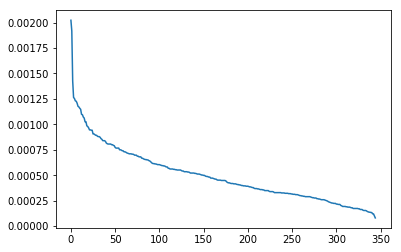

In [72]:
from quick_draw.average_precision import get_err_scores

err_scores = get_err_scores(ground_truth, top3_predictions, len(labels_map))

plt.plot(range(len(err_scores)), [err_score[0] for err_score in err_scores])

In [80]:
print(err_scores[:10])

a = 0
for err_score in err_scores[:200]:
    a += err_score[0]
    
print(a)

[(0.0020232172470978443, 13), (0.001917081260364843, 241), (0.00142620232172471, 61), (0.0012636815920398007, 92), (0.0012537313432835818, 103), (0.0012305140961857376, 122), (0.0012271973466003315, 271), (0.0012072968490878938, 130), (0.0011774461028192368, 65), (0.0011708126036484242, 24)]
0.1339601990049752


## Plot examples

In [90]:
def plot_images(records):
    num_examples = len(records)
    columns = 10
    rows = num_examples // columns + 1
    plt.figure(figsize=(columns * 2, rows * 2.3))
    for i, (image, label_id) in enumerate(records):
        plt.subplot(rows, columns, i + 1)
        plt.imshow(1 - image.reshape((28, 28)), cmap='gray', vmin=0, vmax=1)
        plt.axis('off')
        if label_id != -1:
            plt.title(id2label[label_id])
    
    plt.show()

    
def plot_by_image_ids(image_ids):
    plot_images([bitmaps[image_id] for image_id in image_ids])
        

def plot_class_predictions(label_id, class_info, limit=10):

    for key, title in [
        ('correct', 'Correctly classified as "%s"' % id2label[label_id]),
        ('misclassified', 'Should be classified as "%s"' % id2label[label_id]), 
        ('predicted', 'Incorrectly classified as "%s"' % id2label[label_id]),
    ]:
        image_records = []
        for image_id, label_id in class_info[key][:limit]:
            image_records.append((bitmaps[image_id][0], label_id))
            
        print(title)
        plot_images(image_records)

Correctly classified as "mountain"


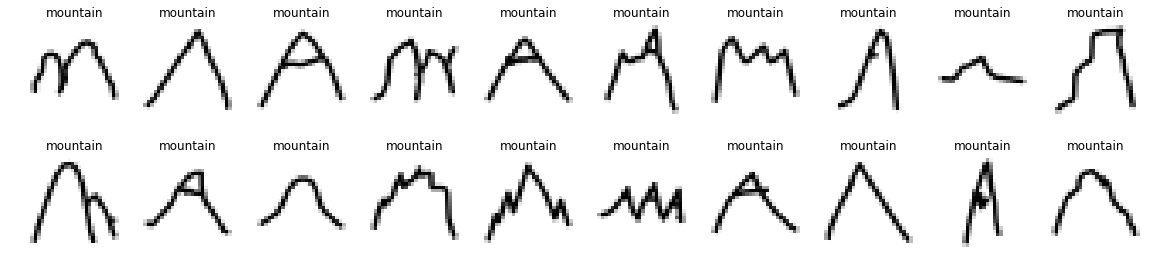

Should be classified as "mountain"


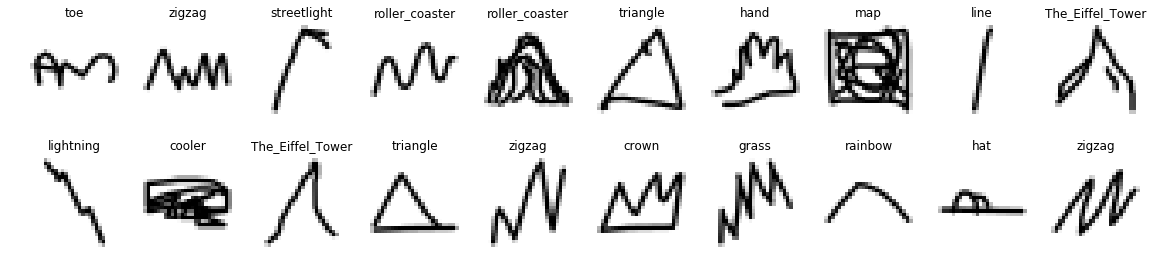

Incorrectly classified as "mountain"


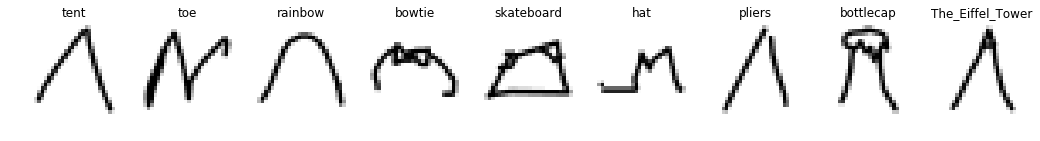

In [91]:
class_id = 67
plot_class_predictions(class_id, classes[class_id], 20)

## Confusion matrix

In [24]:
confusion_list = []
for i, row in enumerate(confusion_matrix):
    for j, value in enumerate(row):
        if i != j and value:
            confusion_list.append((value, (i, j)))

confusion_list.sort(key=lambda x: x[0], reverse=True)
print(len(confusion_list))

6580


In [92]:
confusion_list[:10]

[(48, (3, 129)),
 (46, (235, 4)),
 (38, (49, 257)),
 (37, (326, 176)),
 (36, (178, 42)),
 (35, (146, 241)),
 (34, (272, 49)),
 (30, (4, 235)),
 (30, (72, 20)),
 (30, (122, 191))]

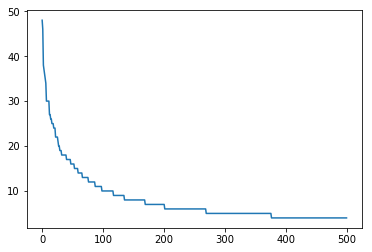

In [25]:
stripped_cl = confusion_list[:500]
plt.plot(range(len(stripped_cl)), [row[0] for row in stripped_cl])

In [59]:
def plot_confusion(confusion_id, limit=20):
    confusion = confusion_list[confusion_id]
    actual_label_id, predicted_label_id = confusion[1]
    actual_label, predicted_label = id2label[actual_label_id], id2label[predicted_label_id]
    
    # plot opposite confusions
    num_confusions = confusion[0]
    percent_confusions = num_confusions / examples_per_class[actual_label_id] * 100

    print('Number of confusions: %d (%.02f%%)' % (num_confusions, percent_confusions))
    print('Actual label: %s' % actual_label)
    print('Predicted label: %s' % predicted_label)
    plot_by_image_ids(confusion_examples[(actual_label_id, predicted_label_id)][:limit])

    # plot opposite confusions
    num_opp_confusions = [value for value, key in confusion_list if key == (predicted_label_id, actual_label_id)]
    num_opp_confusions = num_opp_confusions[0] if num_opp_confusions else 0
    percent_opp_confusions = num_opp_confusions / examples_per_class[predicted_label_id] * 100
    
    print('Number of opposite confusions: %d (%.02f%%)' % (num_opp_confusions, percent_opp_confusions))
    print('Actual label: %s' % predicted_label)
    print('Predicted label: %s' % actual_label)    
    plot_by_image_ids(confusion_examples[(predicted_label_id, actual_label_id)][:limit])

Number of confusions: 24 (15.79%)
Actual label: mug
Predicted label: coffee_cup


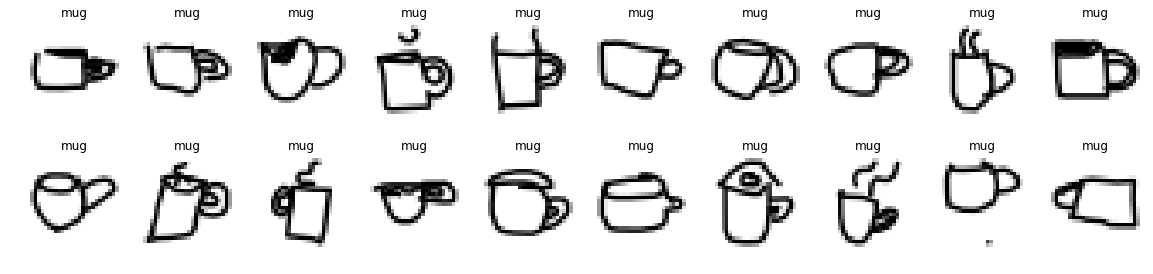

Number of opposite confusions: 38 (20.77%)
Actual label: coffee_cup
Predicted label: mug


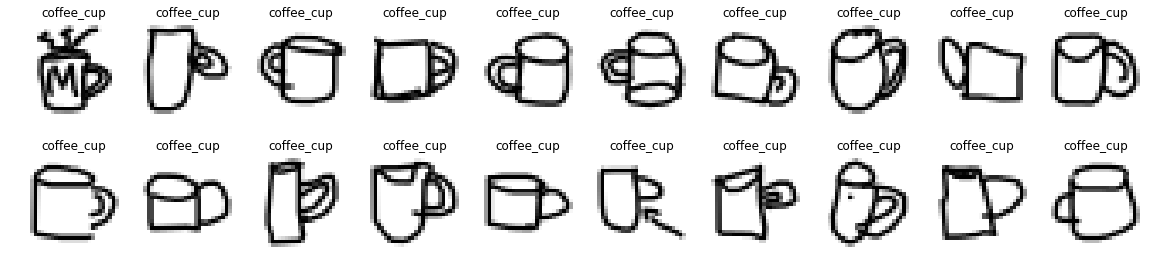

In [63]:
plot_confusion(20)

Number of confusions: 46 (37.10%)
Actual label: cake
Predicted label: birthday_cake


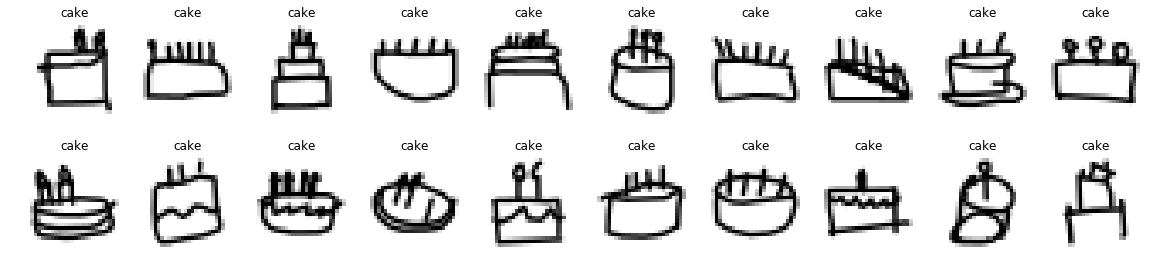

Number of opposite confusions: 30 (20.83%)
Actual label: birthday_cake
Predicted label: cake


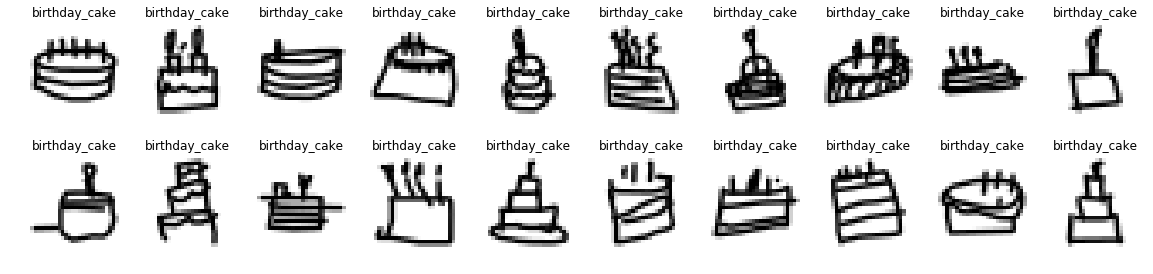

In [61]:
plot_confusion(1)

# Submission

## Read the data

In [70]:
submission_file = project_dir('data/submission/test_simplified.tfrecords')
submission_bitmaps = read_bitmaps(submission_file)

len(submission_bitmaps)

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000


112199

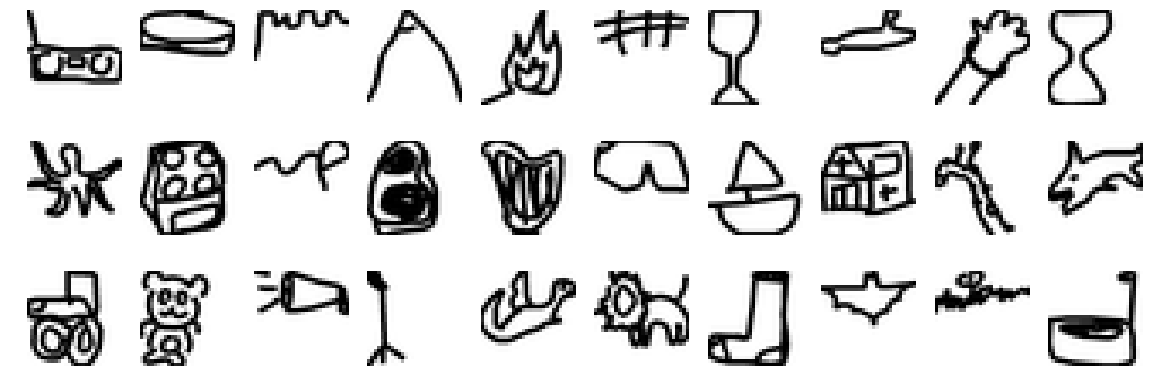

In [71]:
plot_images(submission_bitmaps[:30])

## Generate submission CSV

In [74]:
import csv

with open(project_dir('data/submission/predictions.pickle'), 'rb') as f:
    submission_predictions = pickle.load(f)

print(len(submission_predictions))

csv_path = project_dir('data/submission/test_simplified.csv')
submission_csv_path = project_dir('data/submission/submission.csv')

with open(submission_csv_path, 'w') as fw:
    fw.write('key_id,word\n')

    with open(csv_path) as fr:
        reader = csv.reader(fr)
        next(reader)
        i = 0
        for key_id, _, _ in reader:
            # top 3 labels
            pred_probabilities = submission_predictions[i]['probabilities']
            sorted_pred = sorted([(i, probability) for i, probability in enumerate(pred_probabilities)], 
                                 key=lambda x: x[1], reverse=True)
            top3_labels = ' '.join([id2label[i] for i, _ in sorted_pred[:3]])

            fw.write('%s,%s\n' % (key_id, top3_labels))

            i += 1
            if i % 10000 == 0:
                print(i)


112199
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
